### Show quantile estimation with SGD  "works"

1. Test datasets:
    - Mixsture of 5 Gaussians
    - Sample of 100k from no.1
    - Gausian $\mu = 2, \sigma = 18$
    - Gausian $\mu = 0, \sigma = 0.001$
    - Sample 100 from no.1
    - Sample 100 from no.3
    - Exponential $\lambda$
    - My weird distribution lol
    
4. Test times:
    - 10 $\times$ dataset generation
    - 10 $\times$ SGD ???
    - 10 $\times$ shuffle (does the order matter?)
    
2. Q value: 0.1, 0.3, 0.5, 0.9, 0.99 

3. Step size: 
    - $\alpha_k = 1$
    - $\alpha_k = \frac{2}{\sqrt{k}}$
    - $\alpha_k = \frac{0.002}{\sqrt{k}}$
    - ?
    - ?
    - Why's the Newton method helpful?
       
5. Calculate $E = |q_{batch} - q_{sgd}|$

6. What's a small value of $E$?

7. Investigate the effect of datasize N
    - Convergence rate with same $\alpha_k$?
    - Different Q values?
    - ?

In [9]:
%matplotlib inline

import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell


import numpy as np
import matplotlib.pyplot as plt
import import_ipynb
from plt_quantile_comparison import plot_quantile_shuffles, plot_quantile_generations

In [10]:
distro_list = ['mix_gau', 'gau 1', 'gau 2', 'exp', 'my_distro']

q_vals = [0.1, 0.3, 0.5, 0.9, 0.99]
N_g = 12 # N_generation
N_s = 10 # N_shuffle

N_q = len(q_vals)

In [123]:
# all of the inputs are in the form of list
# e.g. distro = [mix_gaussian], datasize = [100, 100000], stepsize = [2]
def get_n_comp(distro, datasize, stepsize):
    print ('get_compared_setting()', distro, datasize, stepsize)
    if len(distro) > 1:
        if len(datasize)!= 1 or len(stepsize)!=1:
            raise Exception('The number of comp_setting is incorrect')
        return len(distro)
    elif len(datasize) > 1:
        if len(stepsize)!=1:
            raise Exception('The number of comp_setting is incorrect')        
        return len(datasize)
    elif len(stepsize) > 1:
        print ('step size')
        return len(stepsize)
    raise Exception('The number of comp_setting is incorrect')

def generate_setting_lst(distro, datasize, q_lst, g_test, s_test):
    setting_lst = []
    if len(distro)>1:
        for dis in distro:
            setting_lst.append([dis, datasize[0], q_lst, g_test, s_test])
    else:
        for size in datasize:
            setting_lst.append([distro[0], size, q_lst, g_test, s_test])
    return setting_lst

In [124]:
generate_setting_lst([1, 2, 3, 4], [1], q_vals, False, False)

[[1, 1, [0.1, 0.3, 0.5, 0.9, 0.99], False, False],
 [2, 1, [0.1, 0.3, 0.5, 0.9, 0.99], False, False],
 [3, 1, [0.1, 0.3, 0.5, 0.9, 0.99], False, False],
 [4, 1, [0.1, 0.3, 0.5, 0.9, 0.99], False, False]]

### Dataset and quantile generation

In [334]:
# distro_list = ['mix_gau', 'gau 1', 'gau 2', 'exp', 'my_distro']

def generate_single_dataset(distro, datasize):
    if distro == 'gau 1':
        return np.random.normal(2, 18, datasize)
    elif distro == 'gau 2':
        return np.random.normal(0, 0.001, datasize)
    elif distro == 'mix':
        sizes = np.array([0.3, 0.2, 0.1, 0.15, 0.25]) * datasize
        d1 = np.random.normal(2.0, 7.0, int(sizes[0]))
        d2 = np.random.normal(0, 3.7, int(sizes[1]))
        d3 = np.random.normal(-9, 7, int(sizes[2]))
        d4 = np.random.normal(5, 77, int(sizes[3]))
        d5 = np.random.normal(-7, 7, int(sizes[4]))
        mix_lst = np.append(d1, np.append(d2, np.append(d3, np.append(d4, d5))))
        np.random.shuffle(mix_lst)
        return mix_lst
    elif distro == 'exp':
        return np.random.exponential(scale=1, size=datasize)



In [335]:

# data = generate_single_dataset('gau 1', 1000)
# data2 = generate_single_dataset('gau 2', 1000)
# data_mix = generate_single_dataset('mix', 100000)
# data_exp = generate_single_dataset('exp', 1000)

# num_bins = 100
# plt.hist([data, data2], num_bins, alpha = 0.5, label=['a', 'b'])
# plt.hist(data_mix, num_bins, alpha = 0.5, label='mix')
# plt.hist(data_exp, num_bins, alpha = 0.5, label='mix')
# plt.legend()
# plt.show()

In [414]:
def generate_dataset(distro, datasize, g_test, s_test):
    print ('generate_dataset', distro, datasize, g_test, s_test)
#     shape of dataset: 1*Datasize,
    if not g_test and not s_test:
        return generate_single_dataset(distro, datasize)
            
    elif g_test and not s_test:
        generated_dt = np.zeros((N_g, datasize))
        for i in range(N_g):
            generated_dt[i] = generate_single_dataset(distro, datasize)
        return generated_dt
    
    elif s_test and not g_test:
        shuffled_dt = np.zeros((N_s, datasize))
        dt = generate_single_dataset(distro, datasize)
        for i in range(N_s): 
            np.random.shuffle(dt)
            shuffled_dt[i] = dt
        return shuffled_dt
        
    dataset = np.zeros((N_g, N_s, datasize))
    for gen_id in range(N_g):
        dt = generate_single_dataset(distro, datasize)
        for shu_id in range(N_s):
#             print (gen_id, shu_id)
            np.random.shuffle(dt)
            dataset[gen_id][shu_id] = dt
    return dataset


generate_dataset mix 10000 False True
generate_dataset mix 10000 True False


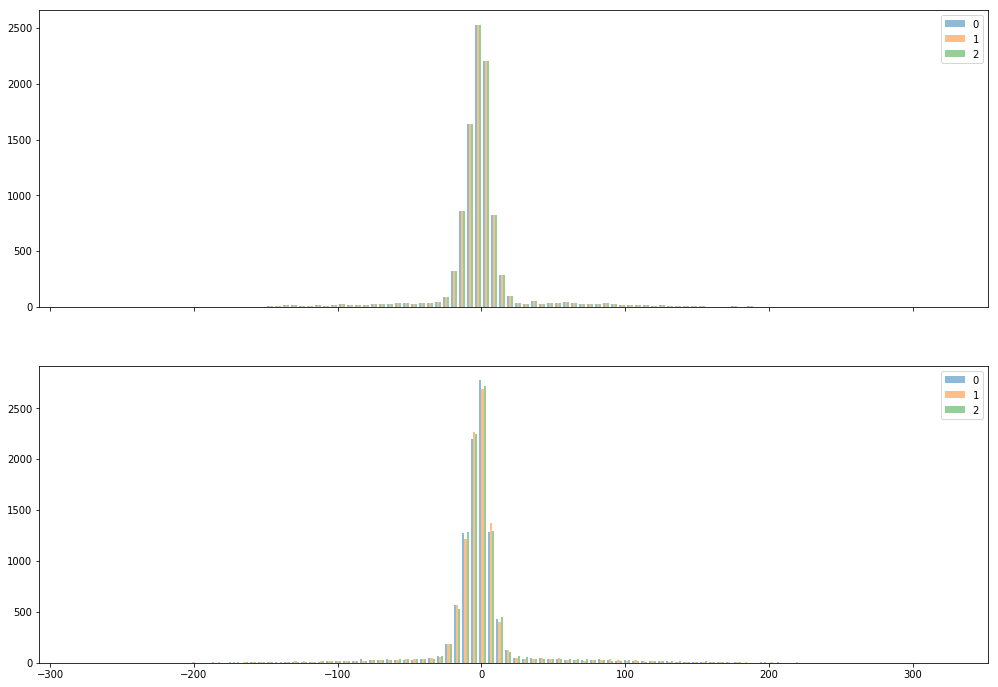

In [415]:
def test_generate_dataset():
    distro = 'mix'
    datasize = 10000

    data_shuffle = generate_dataset(distro, datasize, False, True)
    data_gen = generate_dataset(distro, datasize, True, False)

    fig, (ax1, ax2) = plt.subplots(2,1,sharex=True)
    fig.set_size_inches(17, 12)
    num_bins = 100
    ax1.hist([dt for dt in data_shuffle[:3]], num_bins, alpha = 0.5, label=[str(i) for i in range(20)])
    ax1.legend()
    ax2.hist([dt for dt in data_gen[:3]], num_bins, alpha = 0.5, label=[str(i) for i in range(20)])
    ax2.legend()
    plt.show()
# test_generate_dataset()

In [ ]:
a = np.random.normal(0, )

In [339]:
def generate_q_batches(dataset, q_lst, g_test, s_test):
    print ('generate_q_batches', dataset, g_test, s_test)
    q_batches = 2
    print (q_batches)
    return q_batches

In [134]:
def generate_reusable_data(distro, datasize, q_lst, g_test, s_test):
    print ('generate_reusable_data', (distro, datasize, q_lst, g_test, s_test))
    dataset = generate_dataset(distro, datasize, g_test, s_test)
    q_batches = generate_q_batches(dataset, q_lst, g_test, s_test)
    return dataset, q_batches

def generate_q_sgds(dataset, stepsize, q_lst, g_test, s_test):
#     q_sgd_proc = generate_q_sgd_proc(dataset, stepsize, q_lst, g_test, s_test)
#     q_sgd_res  = generate_q_sgd_res(q_sgd_proc)
#     return q_sgd_res, q_sgd_proc 
    return 0, 1

In [135]:
generate_reusable_data([-1], [100], 1, False, False)

generate_reusable_data ([-1], [100], 1, False, False)
generate_dataset [-1] [100] False False
generate_q_batches [ 2.80957311  3.84232714 -6.55060719 -0.07102296 -3.99687537 -0.50390174
  4.8777567   5.73859821 -1.34587048 -1.20774144 -2.93843706 -1.33961493
 -2.11235858 -6.60492616  4.39955951 -2.22200739  0.61327259 -1.06990307
 -4.54584221  1.07992124 -2.57615656  0.14278133 -0.99154042  0.5690196
 -2.70960983  1.69784631 -4.44539665  5.37610987  0.93888561  1.30634214
 -1.17120066 -0.21066489  1.59776582  1.68157515  4.61267204  2.50868696
 -1.35840874 -2.54259008 -1.76534423  0.5708655   4.21814401  2.54104468
 -0.70432074 -2.80905868  4.65241772 -1.45554025 -0.92171505  0.55047129
  0.95131699  3.1303531   0.82207029  1.19631238  0.88177017  7.60631726
  1.9434452  -0.44366322 -0.40403477 -0.91424303 -3.65049231  4.42266423
  0.59355183  0.21196541  5.2270382  -1.07376868 -1.34083062 -0.55203952
  3.28395175 -2.05972686  5.4802892  -0.29033065 -0.06001905  3.46365425
 -2.20591649

(array([ 2.80957311,  3.84232714, -6.55060719, -0.07102296, -3.99687537,
        -0.50390174,  4.8777567 ,  5.73859821, -1.34587048, -1.20774144,
        -2.93843706, -1.33961493, -2.11235858, -6.60492616,  4.39955951,
        -2.22200739,  0.61327259, -1.06990307, -4.54584221,  1.07992124,
        -2.57615656,  0.14278133, -0.99154042,  0.5690196 , -2.70960983,
         1.69784631, -4.44539665,  5.37610987,  0.93888561,  1.30634214,
        -1.17120066, -0.21066489,  1.59776582,  1.68157515,  4.61267204,
         2.50868696, -1.35840874, -2.54259008, -1.76534423,  0.5708655 ,
         4.21814401,  2.54104468, -0.70432074, -2.80905868,  4.65241772,
        -1.45554025, -0.92171505,  0.55047129,  0.95131699,  3.1303531 ,
         0.82207029,  1.19631238,  0.88177017,  7.60631726,  1.9434452 ,
        -0.44366322, -0.40403477, -0.91424303, -3.65049231,  4.42266423,
         0.59355183,  0.21196541,  5.2270382 , -1.07376868, -1.34083062,
        -0.55203952,  3.28395175, -2.05972686,  5.4

### Plots generation

In [136]:
def draw_charts(q_batches, q_sgd_res, q_sgd_proc, g_test, s_test, charts):
#     return plts
    return 4

def draw_tables(q_batches, q_sgd_res, q_sgd_proc, g_test, s_test, charts):
#     return tbls
    return 5

In [137]:
# Conduct experiments on quantile estimation with SGD with regards to different aspects
# Experiment results are shown in charts and tables
# 
# Return: None? or charts and figures
#
# Inputs: 
#     1. Parameters for the experiments
#         - Settings to change: one of {distro, datasize, stepsize} (all elements are lists/dict)
#         - Settings to control: the left two of {distro, datasize, stepsize}
#                                g_test, s_test
#     2. Values to show in the results
#         - q_values to be compared
#         - charts to be showen in {plt_res, plt_proc, plt_e}
#         - tables to be shown in {tbl_res, tbl_proc}

def quantile_sgd_compare(distro, datasize, stepsize, 
                            g_test=False, s_test=False, q_lst=q_vals, 
                           charts={'plt_res', 'plt_proc', 'plt_e'}, tables={'tbl_res, tbl_proc'}):
    dataset, q_batches = 0, 0
    N_comp = get_n_comp(distro, datasize, stepsize)
    if len(stepsize)!=1:
        setting_lst = generate_setting_lst(distro, datasize, q_lst, g_test, s_test)
    else:
        dataset, q_batches = generate_reusable_data(distro, datasize, q_lst, g_test, s_test)
        
    # for each round, generate all data and comparison results
    for i in range(N_comp):
        if len(setting_lst)!=1:
            print ("generate the {}th dataset and q_batches".format(i))
            lst = setting_lst[i]
            distro, datasize, q_lst, g_test, s_test = lst[0], lst[1], lst[2], lst[3], lst[4]
            dataset, q_batches = generate_reusable_data(distro, datasize, q_lst, g_test, s_test)
            q_sgd_res, q_sgd_proc = generate_q_sgds(dataset, stepsize, q_lst, g_test, s_test)
        else:
            print ('different q_sgd', i)
            q_sgd_res, q_sgd_proc = generate_q_sgds(dataset, stepsize[i], q_lst, g_test, s_test)
        plts = draw_charts(q_batches, q_sgd_res, q_sgd_proc, g_test, s_test, charts)
        tbls = draw_tables(q_batches, q_sgd_res, q_sgd_proc, g_test, s_test, tables)
    # have them together?
    
    return
    

In [138]:
quantile_sgd_compare([1], [2], [4,5])

get_compared_setting() [1] [2] [4, 5]
step size
different q_sgd 0
different q_sgd 1


In [50]:
# plt: errorbar
# https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/errorbar_subsample.html#sphx-glr-gallery-lines-bars-and-markers-errorbar-subsample-py